# Тестовое задание

В папке с заданием два датасета - data_orders - содержит выборку данных по заказам клиентов и включает такие колонки как:
* order_datetime -  время заказа
* order_gk - номер заказа
* order_status_key - статус (4 - отменен клиентом, 9 - отменен системой (reject))
* is_courier_assigned_key - был ли назначен курьер
* cancellations_time_in_seconds - сколько секунд прошло до отмены

data_offers - содержит пары номер заказа - ID оффера, который был предложен курьеру по данному заказу.


В момент когда клиент нажимает на кнопку "Заказать" в приложении, система матчинга подыскивает наиболее релевантых курьеров и предлагаем им заказ. В задании предлагается исследовать некоторые метрики неудачных заказов.

Задание является проверочным и не имеет ничего общего с реальной работой курьеров

#### 0. Подготовка данных, проверка выбросов, аномалий.

**0.1** Импортируем нужные библиотеки для работы.

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from scipy import stats as st
%matplotlib inline

##### 0.2. Импортируем файлы и посмотрим на датасеты.

In [134]:
df_orders = pd.read_csv('data_orders.csv')
df_offers = pd.read_csv('data_offers.csv')

In [135]:
print("-------------Первые 5 строк-------------")
display(df_orders.head())

print("-------------Типы данных-------------")
display(df_orders.info())

print("-------------Форма-------------")
display(df_orders.shape)

print("-------------Количество дубликатов-------------")
display(df_orders.duplicated().sum())

print("-------------Количество пропусков-------------")
display(df_orders.isna().sum())


-------------Первые 5 строк-------------


,order_datetime,order_gk,order_status_key,is_courier_assigned_key,cancellations_time_in_seconds
0,2020-07-22 18:08:07,3000583041974,4,1,198.0
1,2020-07-22 20:57:32,3000583116437,4,0,128.0
2,2020-07-22 12:07:50,3000582891479,4,1,46.0
3,2020-07-22 13:50:20,3000582941169,4,1,62.0
4,2020-07-22 21:24:45,3000583140877,9,0,NaN


-------------Типы данных-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 5 columns):
order_datetime                   10716 non-null object
order_gk                         10716 non-null int64
order_status_key                 10716 non-null int64
is_courier_assigned_key          10716 non-null int64
cancellations_time_in_seconds    7307 non-null float64
dtypes: float64(1), int64(3), object(1)
memory usage: 418.7+ KB


None

-------------Форма-------------


(10716, 5)

-------------Количество дубликатов-------------


0

-------------Количество пропусков-------------


order_datetime                      0
order_gk                            0
order_status_key                    0
is_courier_assigned_key             0
cancellations_time_in_seconds    3409
dtype: int64

##### 0.2.1. Выводы по `df_orders`:
1. Видно, что типы данных в колонках не совсем отражают действительность, изменим это в дальнейшем.
2. Дубликатов нет.
3. Пропуски есть только в столбце `cancellations_time_in_seconds`, посмотрим, чем это может быть вызвано в дальнейшем.


In [136]:
print("-------------Первые 5 строк-------------")
display(df_offers.head())

print("-------------Типы данных-------------")
display(df_offers.info())

print("-------------Форма-------------")
display(df_offers.shape)

print("-------------Количество дубликатов-------------")
display(df_offers.duplicated().sum())

print("-------------Количество пропусков-------------")
display(df_offers.isna().sum())

-------------Первые 5 строк-------------


,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


-------------Типы данных-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334363 entries, 0 to 334362
Data columns (total 2 columns):
order_gk    334363 non-null int64
offer_id    334363 non-null int64
dtypes: int64(2)
memory usage: 5.1 MB


None

-------------Форма-------------


(334363, 2)

-------------Количество дубликатов-------------


0

-------------Количество пропусков-------------


order_gk    0
offer_id    0
dtype: int64

##### 0.2.2 Выводы по `df_offers`:
1. С типами данных проблем нет.
2. Датасет довольно большой, больше 300k строк.
3. Дубликатов и пропусков не наблюдается.

##### 0.3. Предобработка `df_orders`

###### 0.3.1. Изменим тип данных в столбцах.

In [137]:
df_orders.dtypes

order_datetime                    object
order_gk                           int64
order_status_key                   int64
is_courier_assigned_key            int64
cancellations_time_in_seconds    float64
dtype: object

In [138]:
df_orders['order_datetime'] = pd.to_datetime(df_orders['order_datetime'])
df_orders['is_courier_assigned_key'] = df_orders['is_courier_assigned_key'].astype(bool)
# cancellations_time_in_seconds не превращаем пока что в int из-за NaN

###### 0.3.2. Посмотрим детальнее на пропуски.

In [139]:
df_orders[df_orders['cancellations_time_in_seconds'].isnull() == True].sample(5)

,order_datetime,order_gk,order_status_key,is_courier_assigned_key,cancellations_time_in_seconds
8520,2020-07-22 16:59:09,3000578027099,9,False,NaN
4653,2020-07-22 09:02:01,3000627808064,9,False,NaN
9992,2020-07-22 01:55:07,3000617651301,9,False,NaN
3542,2020-07-22 10:32:21,3000577225736,9,False,NaN
1675,2020-07-22 23:16:48,3000594448223,9,False,NaN


В основном пропуски по времени отмены заказа только там, где:
1. **Не назначен курьер.**
2. **Заказ отменен системой.**

- Убедимся в этом полностью, проверив, есть ли такие строки, где есть значение **NaN и True**.
- А потом проверим строки, где может быть значение **4 и NaN**.

In [140]:
df_orders[(df_orders['cancellations_time_in_seconds'].isnull() == True) & (df_orders['is_courier_assigned_key'] == True)]

,order_datetime,order_gk,order_status_key,is_courier_assigned_key,cancellations_time_in_seconds
1158,2020-07-22 16:49:55,3000631256425,9,True,NaN
6881,2020-07-22 00:44:03,3000630156338,9,True,NaN
7968,2020-07-22 00:12:02,3000600112433,9,True,NaN


1 вывод не подтвердился, проверим второй.

In [141]:
df_orders[(df_orders['cancellations_time_in_seconds'].isnull() == True) & (df_orders['order_status_key'] != 9)].count()

order_datetime                   0
order_gk                         0
order_status_key                 0
is_courier_assigned_key          0
cancellations_time_in_seconds    0
dtype: int64

Получили, что пропуски только там, где заказ отменен системой, теперь давайте проверим следующее:
- Есть ли строки, где заказ был отменен системой и указывалось количество секунд до отмены?


In [142]:
df_orders[(df_orders['cancellations_time_in_seconds'].isnull() == False) & (df_orders['order_status_key'] == 9)].count()

order_datetime                   0
order_gk                         0
order_status_key                 0
is_courier_assigned_key          0
cancellations_time_in_seconds    0
dtype: int64

Таким строк нет, сделаем выводы и составим гипотезы:

### Выводы и гипотезы по пропускам:
- Пропуски во времени отмены заказа есть только там, где заказ был отменен системой.

**Это может быть обусловлены несколькими причинами.**
1. *Вполне может быть так, что время заказа просто не записывается, если заказ был отменен системой.*
2. *Происходит технический сбой.*
3. *Взяли маленькую выборку.*

**Чтобы исправить данную проблему и выяснить точную причину, нужно обратиться к техническим специалистом и предложить данные варианты решения:**
- Если время заказа просто не записывается, если заказ был отменен системой, то мы просто заполним эти строки нулями.
- Если происходит технический сбой, то это необходимо, конечно же, исправить.
- Взять другую выборку.

##### 0.4. Категоризируем даты и сделаем отдельные столбцы для времени.

Посмотрим, за один ли год и месяц у нас выборка из данных.

In [143]:
display(df_orders['order_datetime'].dt.year.value_counts())
display(df_orders['order_datetime'].dt.month.value_counts())
display(df_orders['order_datetime'].dt.day.value_counts())

2020    10716
Name: order_datetime, dtype: int64

7    10716
Name: order_datetime, dtype: int64

22    10716
Name: order_datetime, dtype: int64

***Получается так, что у нас очень маленькая выборка всего лишь за 1 день - 22 июля 2020 года, поэтому сделаем колонку только отдельно для часов.***

In [144]:
df_orders['hour'] = df_orders['order_datetime'].dt.hour

###### 0.5. Посмотрим на распределения во времени отмены заказов.

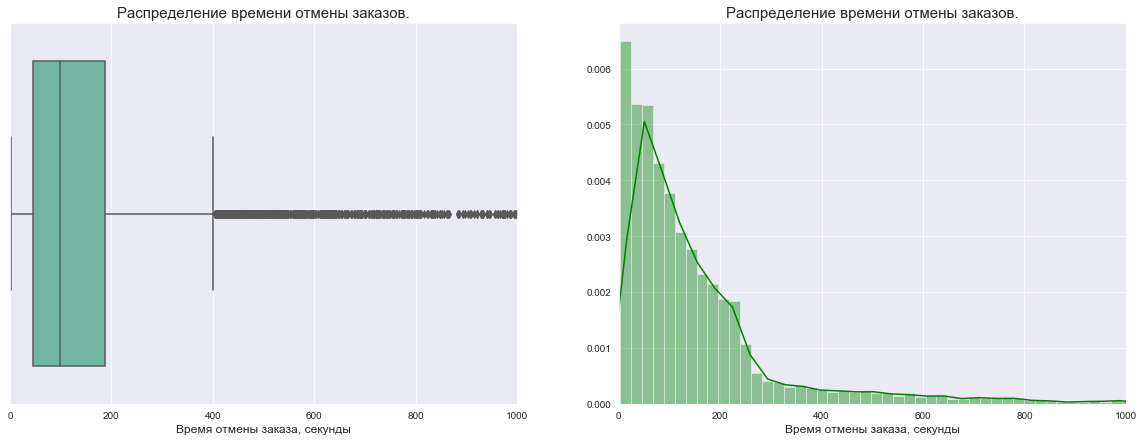

count    7307.000000
mean      157.892021
std       213.366963
min         3.000000
25%        45.000000
50%        98.000000
75%       187.500000
95%       544.400000
99%       996.940000
max      4303.000000
Name: cancellations_time_in_seconds, dtype: float64

In [145]:
temp = df_orders[df_orders['cancellations_time_in_seconds'].isnull() == False]

sns.set_style('darkgrid')
plt.figure(figsize = (20,7))
plt.title('Распределение времени отмены заказа.', fontsize = 15)

plt.subplot(1,2,1)
sns.boxplot(temp['cancellations_time_in_seconds'], palette = 'Set2')
plt.title('Распределение времени отмены заказов.', fontsize = 15)
plt.xlabel('Время отмены заказа, секунды', fontsize = 12)
plt.xlim(0,1000)


plt.subplot(1,2,2)
sns.distplot(temp['cancellations_time_in_seconds'], color = 'green', bins = 200)
plt.title('Распределение времени отмены заказов.', fontsize = 15)
plt.xlabel('Время отмены заказа, секунды', fontsize = 12)
plt.xlim(0,1000)


plt.show()

temp['cancellations_time_in_seconds'].describe(percentiles = [.25, 0.5, 0.75, 0.95, 0.99])

###### Выводы:
1. Очень большое количество выбросов, то есть аномальных значений, видно, что 95% значений находятся в области до 545 секунд, то есть до 10 минут, что уже очень большое значение.
2. Нельзя сказать, за какое время обычно (нормально) происходит отмена, так как гистограмма показывает экспоненциальное распределение, медиана и среднее значения не находятся рядом.

###### 0.5. Посмотрим на распределения в часах.

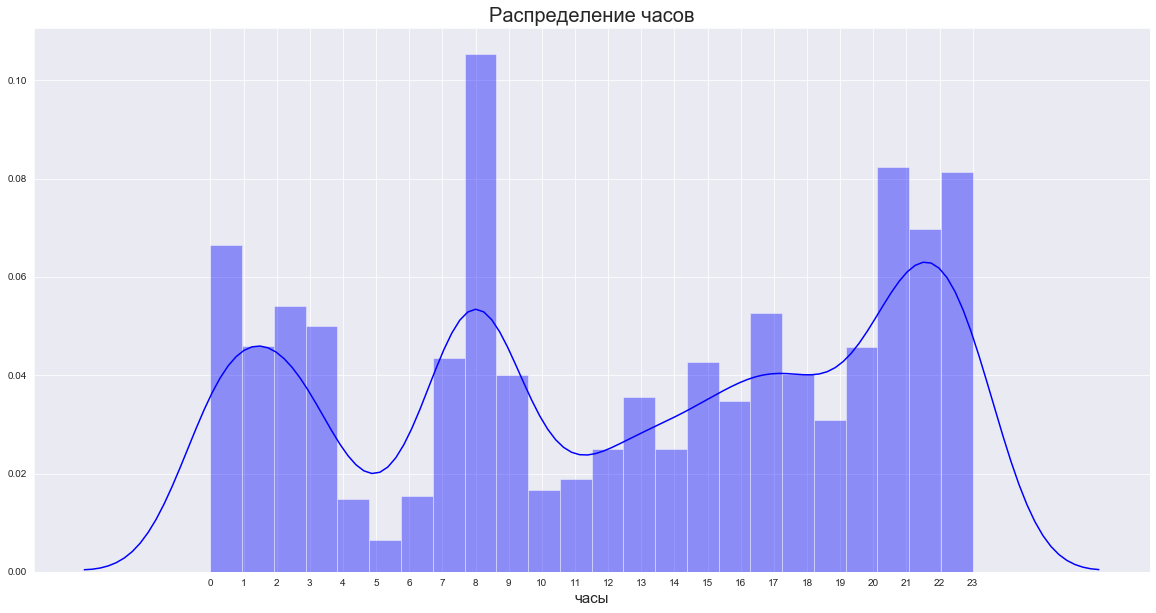

In [163]:
plt.figure(figsize = (20,10))

sns.distplot(df_orders['hour'], color = 'blue', bins = 24) # 24 bins, потому что у нас 24 часа всего :)
plt.title('Распределение часов', fontsize = 20)
plt.xlabel('часы', fontsize = 15)
plt.xticks(range(0,24,1))


plt.show()

##### Выводы:
- Наибольшее кол-во заказов приходится на 8 часов и с 20 до 23 часов. Это может быть обусловлено предрабочим и послерабочим временем. Также у нас нет информации, из одного часового пояса у нас датасет или нет, тогда ситуация бы поменялась.
- Меньше всего заказов происходит с 4 до 6 часов и с 10 до 12 часов.
- В остальных случаях ситуация примерно одинаковая.

### Ответы на вопросы

#### 1. Для всех ли заказов нашлись офферы курьерам?

Ответ на данный вопрос можно дать таким образом:

- Надо посмотреть на строки, где был назначен курьер и посмотреть на строки offer_id, если строка offer_id окажется пустой, то это значит, что курьеру не достался оффер.

In [221]:
df1 = df_orders.merge(df_offers, how = 'outer', on = 'order_gk')
# объединяем методом outer, чтобы если найдутся пропуски в offer_id, это нам покажет, что курьер назначен, но у него нет offer

In [223]:
df1.query('is_courier_assigned_key == True and offer_id == "NaN"')

,order_datetime,order_gk,order_status_key,is_courier_assigned_key,cancellations_time_in_seconds,hour,offer_id
49,2020-07-22 16:55:28,3000583016613,4.0,True,188.0,16.0,NaN
119,2020-07-22 17:45:10,3000632371531,4.0,True,123.0,17.0,NaN
120,2020-07-22 08:03:03,3000632121951,4.0,True,171.0,8.0,NaN
184,2020-07-22 23:58:55,3000632521657,4.0,True,836.0,23.0,NaN
500,2020-07-22 16:23:15,3000623015780,4.0,True,135.0,16.0,NaN
...,...,...,...,...,...,...,...
34189,2020-07-22 12:12:54,3000554821880,4.0,True,104.0,12.0,NaN
34271,2020-07-22 17:23:50,3000554947422,4.0,True,407.0,17.0,NaN
34278,2020-07-22 16:48:53,3000554946396,4.0,True,253.0,16.0,NaN
34284,2020-07-22 15:51:29,3000554921654,4.0,True,106.0,15.0,NaN


**1. Ответ**: Нет.

**Предполагаемые причины**:
- Курьер мог был быть назначен по ошибке
- Курьер сначала мог быть назначен, а потом отменили заказ и соответственно оффер курьеру не достался
- Сбои в системе

*Нужно будет узнать, как работает логика записи в датасет, и пофиксить проблемы, исходя из этого.*

#### 2. Если нашлись такие заказы, на которых не назначены курьеры, то чего больше - отмен клиентом или реджектов системы?

Пояснение:
- Сначала надо найти заказы, на которые не назначены курьеры, а затем посчитать кол-во отменененных клиентом и реджектов и сравнить.

In [236]:
df2 = df_orders.query('is_courier_assigned_key == False')

rejected_system = df2.query('order_status_key == 9')['order_status_key'].count()
rejected_client = df2.query('order_status_key == 4')['order_status_key'].count()

print(f"Отменено системой {rejected_system} заказов.")
print(f"Отменено клиентами {rejected_client} заказов.", end = '\n\n')

if rejected_system > rejected_client:
    print('Больше заказов отменено системой.')
elif rejected_system < rejected_client:
    print('Больше заказов отменено клиентами.')
else:
    print('Количество отмененных заказов поровну')

Отменено системой 3406 заказов.
Отменено клиентами 4496 заказов.

Больше заказов отменено клиентами.


**2. Ответ**: Больше заказов отменено клиентами.

**Предполагаемые причины:**
- Разница в тысячу заказов, в принципе клиентами могли отменяться заказы, которые либо были сделаны по ошибке, либо клиент ждал слишком долго, при чем долго у каждого человека это понятие субъективное.
- Системой могли отменяться заказы из-за нехватки курьеров, товара, который заказали и иным подобным причинам.

#### 3. Какова доля заказов с назначенным курьером среди заказов, отмененных системой?

1. Найдем заказы, отмененные системой.
2. Поделим заказы с назначенным курьером на все заказы.

In [243]:
df3 = df_orders.query('order_status_key == 9')

In [252]:
conversion =  df3.query('is_courier_assigned_key == True').shape[0] / df3.shape[0]

print(f"Доля отмененных заказов = {conversion}")

Доля отмененных заказов = 0.0008800234672924611


**3. Ответ**: Доля равна =  *0.0008800234672924611* (крайне мала).

###### Причины:
- Скорее всего это сбои в системе, если это реально окажется так, то мы может просто отбросить их, ничего не случится.
- Либо всё в порядке и система работает так, что сначала отменяется заказ, а курьер остается без заказа, в любом случае надо узнать, что происходит на самом деле.

#### 4. Получите среднее времени до отмены (cancellations_time_in_seconds) с назначенным курьером и без, по часам.  Можно ли сделать выводы по полученной таблице?

In [254]:
df4_with = df_orders.query('is_courier_assigned_key == True')['hour']
df4_without = df_orders.query('is_courier_assigned_key == False')['hour']

Здесь я буду использовать `distplot` (`histplot`) для наглядности. Среднее время, медиану и т.п. получим через метод .describe()

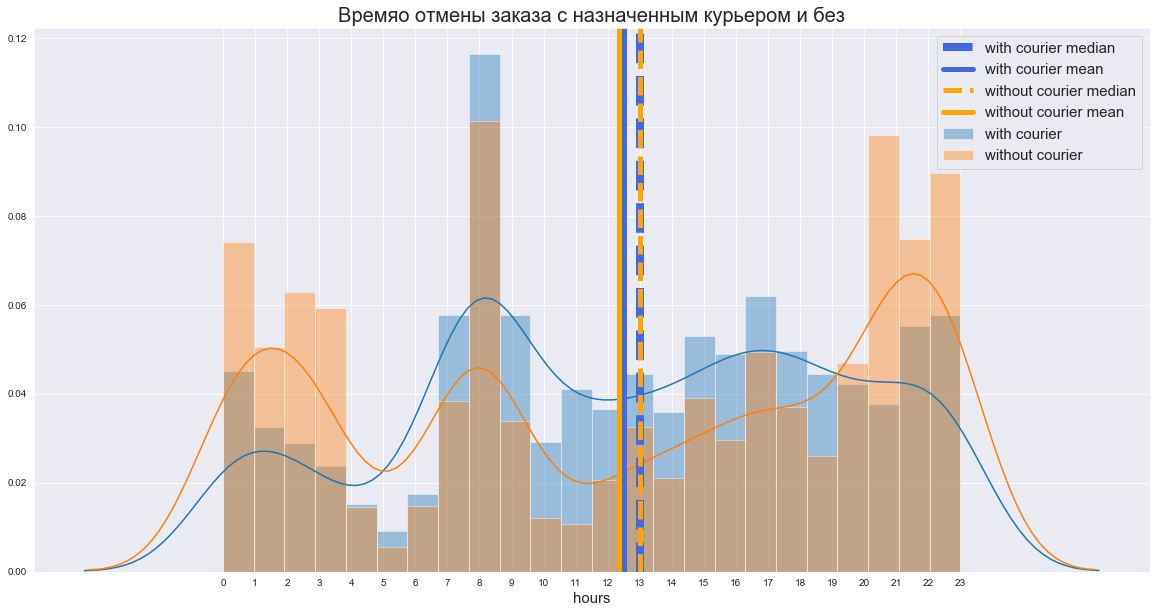

In [307]:
plt.figure(figsize = (20,10))

sns.distplot(df4_with, bins = 24, label = 'with courier')
sns.distplot(df4_without, bins = 24, label = 'without courier')

#with median
plt.axvline(df4_with.median(), color = 'royalblue', linewidth = 8, linestyle = 'dashed', label = 'with courier median')
#with mean
plt.axvline(df4_with.mean(), color = 'royalblue', linewidth = 5, label = 'with courier mean')


#without median
plt.axvline(df4_without.median(), color = 'orange', linewidth = 5, linestyle = 'dashed', label = 'without courier median')
#without mean
plt.axvline(df4_without.mean(), color = 'orange', linewidth = 5, label = 'without courier mean')


plt.xlabel('hours', fontsize = 15)
plt.xticks(range(0,24,1))

plt.title('Времяо отмены заказа с назначенным курьером и без', fontsize = 20)
plt.legend(prop={'size': 15})


plt.show()

Можно наглядно увидеть, что медиана и средние почти одинаковые, посмотрим статистику с помощью `.describe` и сделаем окончательные выводы.

In [342]:
pd.merge(df4_with.describe(percentiles = [.25, .50, 0.75, 0.95, 0.99]),
         df4_without.describe(percentiles = [.25, .50, 0.75, 0.95, 0.99]),
         left_index=True, right_index=True,
         suffixes=('s with courier', 's without courier'))

,hours with courier,hours without courier
count,2814.000000,7902.000000
mean,12.511727,12.353581
std,6.662850,7.985971
min,0.000000,0.000000
25%,8.000000,4.000000
50%,13.000000,13.000000
75%,18.000000,21.000000
95%,23.000000,23.000000
99%,23.000000,23.000000
max,23.000000,23.000000


**4. Ответ**:

Среднее время с курьером и без одинаковое = ~12.5

**Выводы:**
- В заказах без курьера большинство сбоев происходит вечером и ночью.
- В заказах с курьерами, наоборот, днем.

Быть может, что заказы без курьера отменяются вечером и ночью банально по той причине, что для большинства людей это нерабочие часы и просто невозможно назначить курьера.


#### 5. Постройте график распределения фейлов по часам - наблюдается ли тендеция, что в какие то часы доля той или иной категории аномально высока?

По стечению обстоятельств я уже строил этот график сверху, но продублирую еще раз.

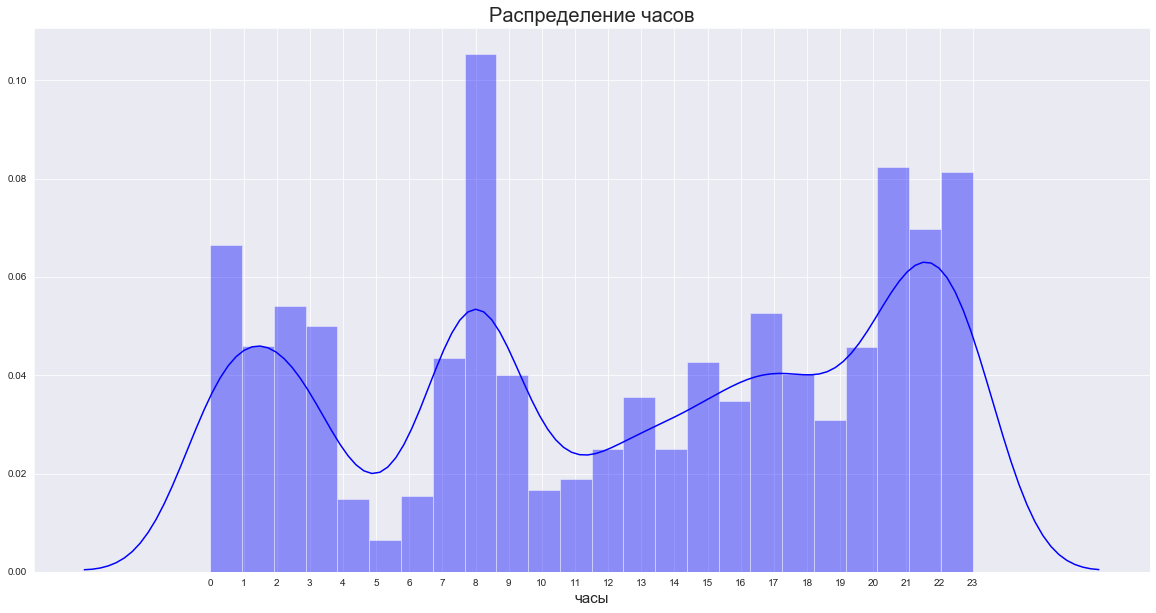

In [343]:
plt.figure(figsize = (20,10))

sns.distplot(df_orders['hour'], color = 'blue', bins = 24) # 24 bins, потому что у нас 24 часа всего :)
plt.title('Распределение часов', fontsize = 20)
plt.xlabel('часы', fontsize = 15)
plt.xticks(range(0,24,1))


plt.show()

**5. Ответ**: Да, наблюдается.

##### Выводы:
- Наибольшее кол-во заказов приходится на 8 часов и с 20 до 23 часов. Это может быть обусловлено предрабочим и послерабочим временем. Также у нас нет информации, из одного часового пояса у нас датасет или нет, тогда ситуация бы поменялась.
- Меньше всего заказов происходит с 4 до 6 часов и с 10 до 12 часов.
- В остальных случаях ситуация примерно одинаковая.